In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pprint import pformat

from hloc import extract_features, match_features, pairs_from_covisibility
from hloc import colmap_from_nvm, triangulation, localize_sfm, visualization

# Pipeline for outdoor day-night visual localization

## Setup
Here we declare the paths to the dataset, the reconstruction and localization outputs, and we choose the feature extractor and the matcher. You only need to download the [Aachen Day-Night dataset](https://www.visuallocalization.net/datasets/) and put it in `datasets/aachen/`, or change the path.

In [2]:
# dataset = Path('datasets/aachen/')  # change this if your dataset is somewhere else
dataset = Path('/data/aachen/')  # change this if your dataset is somewhere else
images = dataset / 'images/images_upright/'

pairs = Path('pairs/aachen/')
sfm_pairs = pairs / 'pairs-db-covis20.txt'  # top 20 most covisible in SIFT model
# loc_pairs = pairs / 'pairs-query-netvlad50.txt'  # top 50 retrieved by NetVLAD
loc_pairs = pairs / 'pairs-query-netvlad20-small.txt'  # top 50 retrieved by NetVLAD

outputs = Path('outputs/aachen_small/')  # where everything will be saved
reference_sfm = outputs / 'sfm_superpoint+superglue'  # the SfM model we will build
results = outputs / 'Aachen_hloc_superpoint+superglue_netvlad50.txt'  # the result file

In [3]:
# list the standard configurations available
# print(f'Configs for feature extractors:\n{pformat(extract_features.confs)}')
# print(f'Configs for feature matchers:\n{pformat(match_features.confs)}')

In [4]:
# pick one of the configurations for extraction and matching
# you can also simply write your own here!
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

## Extract local features for database and query images

In [5]:
feature_path = extract_features.main(feature_conf, images, outputs)

[02/03/2022 06:28:35 INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[02/03/2022 06:28:35 INFO] Found 5426 images in root /data/aachen/images/images_upright.
[02/03/2022 06:29:05 INFO] Skipping the extraction.


The function returns the path of the file in which all the extracted features are stored.

## Generate pairs for the SfM reconstruction
Instead of matching all database images exhaustively, we exploit the existing SIFT model to find which image pairs are the most covisible. We first convert the SIFT model from the NVM to the COLMAP format, and then do a covisiblity search, selecting the top 20 most covisibile neighbors for each image.

In [6]:
colmap_from_nvm.main(
    dataset / '3D-models/aachen_cvpr2018_db.nvm',
    dataset / '3D-models/database_intrinsics.txt',
    dataset / 'aachen.db',
    outputs / 'sfm_sift')

[02/03/2022 06:29:06 INFO] Found 13026 images and 13026 cameras in database.
[02/03/2022 06:29:06 INFO] Reading the NVM model...
[02/03/2022 06:29:06 INFO] Reading 4328 cameras...
[02/03/2022 06:29:06 INFO] Reading 4328 images...
[02/03/2022 06:29:06 INFO] Reading 1652687 points...


100%|██████████| 1652687/1652687 [00:44<00:00, 36936.10pts/s]

[02/03/2022 06:29:50 INFO] Parsing image data...


[02/03/2022 06:30:18 INFO] Writing the COLMAP model...
[02/03/2022 06:32:08 INFO] Done.


In [7]:
pairs_from_covisibility.main(
    outputs / 'sfm_sift', sfm_pairs, num_matched=20)

[02/03/2022 06:32:10 INFO] Reading the COLMAP model...
[02/03/2022 06:32:52 INFO] Extracting image pairs from covisibility info...


100%|██████████| 4328/4328 [01:29<00:00, 48.57it/s] 

[02/03/2022 06:34:21 INFO] Found 85515 pairs.


## Match the database images

In [8]:
sfm_match_path = match_features.main(matcher_conf, sfm_pairs, feature_conf['output'], outputs)

[02/03/2022 06:34:22 INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 85515/85515 [00:00<00:00, 964766.07it/s]

[02/03/2022 06:35:53 INFO] Finished exporting matches.


The function returns the path of the file in which all the computed matches are stored.

## Triangulate a new SfM model from the given poses
We triangulate the sparse 3D pointcloud given the matches and the reference poses stored in the SIFT COLMAP model.

In [9]:
triangulation.main(
    reference_sfm,
    outputs / 'sfm_sift',
    images,
    sfm_pairs,
    feature_path,
    sfm_match_path,
    colmap_path='colmap')  # change if COLMAP is not in your PATH

[02/03/2022 06:35:53 INFO] Creating an empty model.
[02/03/2022 06:36:16 WARNING] The database already exists, deleting it.
[02/03/2022 06:36:16 INFO] Importing features into the database...


100%|██████████| 4328/4328 [00:43<00:00, 99.89it/s] 


[02/03/2022 06:37:00 INFO] Importing matches into the database...


100%|██████████| 85515/85515 [00:28<00:00, 2978.20it/s]


[02/03/2022 06:37:30 INFO] Performing geometric verification of the matches...
[02/03/2022 06:53:17 INFO] Running the triangulation with command:
colmap point_triangulator --database_path outputs/aachen_small/sfm_superpoint+superglue/database.db --image_path /data/aachen/images/images_upright --input_path outputs/aachen_small/sfm_superpoint+superglue/empty --output_path outputs/aachen_small/sfm_superpoint+superglue --Mapper.ba_refine_focal_length 0 --Mapper.ba_refine_principal_point 0 --Mapper.ba_refine_extra_params 0
[02/03/2022 07:10:52 INFO] Finished the triangulation with statistics:
{'mean_reproj_error': 1.451068,
 'mean_track_length': 6.115833,
 'num_observations': 8015313,
 'num_observations_per_image': 1851.966959,
 'num_reg_images': 4328,
 'num_sparse_points': 1310584}


## Match the query images
Here we assume that the localization pairs are already computed using image retrieval (NetVLAD). To generate new pairs from your own global descriptors, have a look at `hloc/pairs_from_retrieval.py`. These pairs are also used for the localization - see below.

In [10]:
loc_match_path = match_features.main(matcher_conf, loc_pairs, feature_conf['output'], outputs)

[02/03/2022 07:10:52 INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
Loaded SuperGlue model ("outdoor" weights)


100%|██████████| 40/40 [00:00<00:00, 293307.97it/s]

[02/03/2022 07:11:16 INFO] Finished exporting matches.


## Localize!
Perform hierarchical localization using the precomputed retrieval and matches. The file `Aachen_hloc_superpoint+superglue_netvlad50.txt` will contain the estimated query poses. Have a look at `Aachen_hloc_superpoint+superglue_netvlad50.txt_logs.pkl` to analyze some statistics and find failure cases.

In [11]:
localize_sfm.main(
    reference_sfm,
    dataset / 'queries/*_time_queries_with_intrinsics.txt',
    loc_pairs,
    feature_path,
    loc_match_path,
    results,
    covisibility_clustering=False)  # not required with SuperPoint+SuperGlue

[02/03/2022 07:11:16 INFO] Imported 824 images from day_time_queries_with_intrinsics.txt
[02/03/2022 07:11:16 INFO] Imported 98 images from night_time_queries_with_intrinsics.txt
[02/03/2022 07:11:16 INFO] Reading 3D model...
[02/03/2022 07:11:39 INFO] Starting localization...


  0%|          | 0/922 [00:00<?, ?it/s]

[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140520_182846.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140520_211432.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_135037.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_135047.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_134943.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_135321.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_135225.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140520_211801.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images 

[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130210_165320.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130210_165400.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_133240.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-18_13-08-53_664.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_135713.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130210_165902.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130210_170019.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140520_183116.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No 

[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130210_164206.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130210_164238.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_134202.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130210_164244.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_134209.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_134213.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130210_164256.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130210_164322.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images 

 22%|██▏       | 202/922 [00:00<00:00, 1934.31it/s]

[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-01-28_14-41-04_244.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-04_14-20-50_904.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-01-28_14-40-02_921.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140520_211912.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140520_182738.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130302_145531.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140520_211729.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2011-12-29_15-31-19_299.jpg. Skipping...
[02/03/2022 

[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2011-12-29_15-10-33_314.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_095645.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_133039.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_133102.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2011-12-17_15-00-40_564.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_133028.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140520_211823.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130210_165611.jpg. Skipping...
[02/03/2022 07:11:39 WARNI

[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130210_164947.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus5x/IMG_20161227_160713.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus5x/IMG_20161227_162905.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2011-12-29_15-35-03_214.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_133144.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-04-01_17-53-05_488.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140520_211849.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-11_16-05-04_241.jpg. Skipping...
[02/03/2022 07:11

[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130210_164224.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_135349.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130210_165539.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140520_211939.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_095640.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-04-01_17-50-32_648.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-04-01_17-51-28_674.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-04-01_17-54-56_5.jpg. Skipping...
[02/03/2022 07:11:39 

 46%|████▌     | 424/922 [00:00<00:00, 2097.12it/s]

[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-11_15-57-37_244.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-04-21_19-07-46_32.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-04-21_19-07-58_895.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-11_16-05-22_472.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2011-10-13_14-39-23_451.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_134111.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-04-21_19-08-10_84.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-04-21_19-08-20_123.jpg. Skipp

[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-11_15-54-22_239.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_133959.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140520_211755.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130210_163450.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2011-09-18_19-51-48_277.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_134720.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_135132.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-04-21_19-06-12_928.jpg. Skipping...
[02/03/2022 07:11:3

[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-04_14-26-36_868.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-04_14-24-57_766.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_134229.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2011-10-13_15-23-06_588.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-04-01_17-53-25_203.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_135431.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_134250.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-04-21_19-05-53_128.jpg. Skipping...
[02/0

[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_133735.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-11_16-12-51_455.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_134642.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_133725.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_134624.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2011-10-01_14-33-40_719.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2011-10-13_15-22-10_39.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-11_16-07-09_767.jpg. Skipping...
[02/03/2022 0

 71%|███████▏  | 657/922 [00:00<00:00, 1958.50it/s]

[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-11_15-54-30_83.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2011-09-18_19-49-27_741.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-01-01_11-00-20_21.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-01-28_14-42-30_955.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130210_165559.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-11_15-53-41_116.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2011-09-18_19-48-09_199.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2011-09-18_19-48-01_445.jpg. Skipp

[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-04_14-21-52_735.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-04_14-21-34_646.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-04_14-21-18_397.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-04_14-21-05_53.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-01-28_14-43-44_776.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-04_14-20-28_124.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-01-28_15-19-19_648.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-04_14-22-01_386.jp

[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130302_150016.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20140521_134606.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2011-10-13_14-42-58_635.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130302_150032.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2011-10-13_14-43-11_783.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2012-02-04_14-23-47_959.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/nexus4/IMG_20130302_150051.jpg. Skipping...
[02/03/2022 07:11:39 WARNING] No images retrieved for query image query/day/milestone/2011-10-13_14-43-36_947.jpg. Skipping...
[02/03/2022 

 93%|█████████▎| 855/922 [00:00<00:00, 717.99it/s] 

[02/03/2022 07:11:40 WARNING] No images retrieved for query image query/night/nexus5x/IMG_20161227_173141.jpg. Skipping...
[02/03/2022 07:11:40 WARNING] No images retrieved for query image query/night/nexus5x/IMG_20161227_173158.jpg. Skipping...
[02/03/2022 07:11:40 WARNING] No images retrieved for query image query/night/nexus5x/IMG_20161227_173202.jpg. Skipping...
[02/03/2022 07:11:40 WARNING] No images retrieved for query image query/night/nexus5x/IMG_20161227_173206.jpg. Skipping...
[02/03/2022 07:11:40 WARNING] No images retrieved for query image query/night/nexus5x/IMG_20161227_173209.jpg. Skipping...
[02/03/2022 07:11:40 WARNING] No images retrieved for query image query/night/nexus5x/IMG_20161227_173326.jpg. Skipping...
[02/03/2022 07:11:40 WARNING] No images retrieved for query image query/night/nexus5x/IMG_20161227_190424.jpg. Skipping...
[02/03/2022 07:11:40 WARNING] No images retrieved for query image query/night/nexus5x/IMG_20161227_190941.jpg. Skipping...
[02/03/2022 07:1

100%|██████████| 922/922 [00:00<00:00, 981.40it/s]

[02/03/2022 07:11:40 INFO] Localized 2 / 922 images.
[02/03/2022 07:11:40 INFO] Writing poses to outputs/aachen_small/Aachen_hloc_superpoint+superglue_netvlad50.txt...
[02/03/2022 07:11:40 INFO] Writing logs to outputs/aachen_small/Aachen_hloc_superpoint+superglue_netvlad50.txt_logs.pkl...
[02/03/2022 07:11:40 INFO] Done!


## Visualizing the SfM model
We visualize some of the database images with their detected keypoints.

Color the keypoints by track length: red keypoints are observed many times, blue keypoints few.

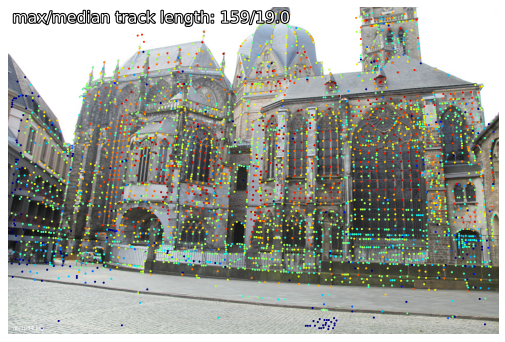

In [12]:
visualization.visualize_sfm_2d(reference_sfm, images, n=1, color_by='track_length')

Color the keypoints by visibility: blue if sucessfully triangulated, red if never matched.

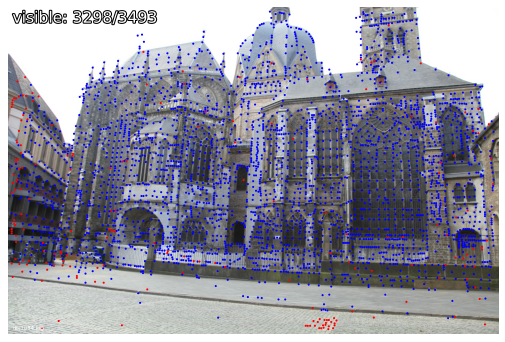

In [13]:
visualization.visualize_sfm_2d(reference_sfm, images, n=1, color_by='visibility')

Color the keypoints by triangulated depth: red keypoints are far away, blue keypoints are closer.

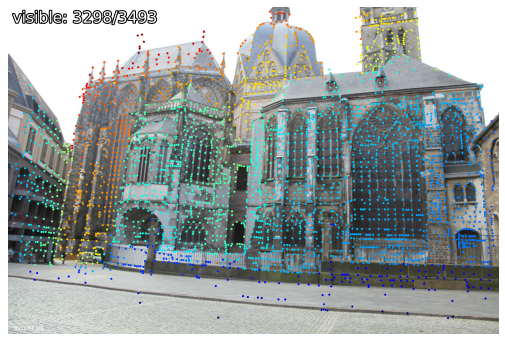

In [14]:
visualization.visualize_sfm_2d(reference_sfm, images, n=1, color_by='depth')

## Visualizing the localization
We parse the localization logs and for each query image plot matches and inliers with a few database images.

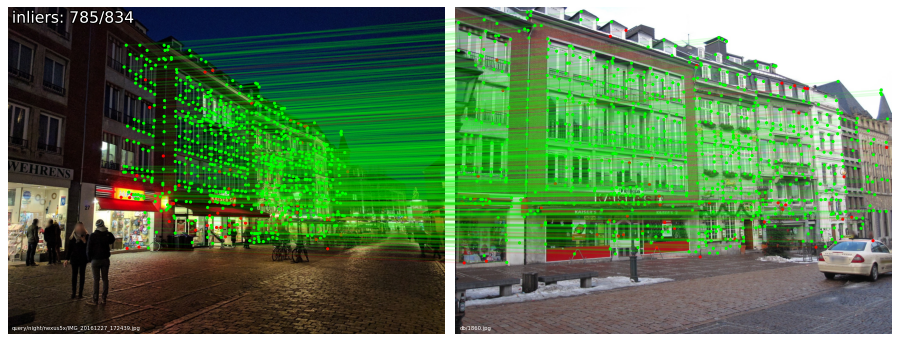

In [15]:
visualization.visualize_loc(
    results, images, reference_sfm, n=1, top_k_db=1, prefix='query/night', seed=2)